In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
# Configure matplotlib
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 14
})

In [3]:
# Load the log file
log_file = 'log_files/logxxxx.log'
data = pd.read_csv(log_file)

# Display the first few rows and columns
print("Columns:", data.columns.tolist())
print("\nFirst few rows:")
print(data.head())
print(f"\nTotal data points: {len(data)}")

Columns: ['time', 'x', 'y', 'z', 'yaw', 'ctrl_comp_time', 'rollout_comptime', 'x_ref', 'y_ref', 'z_ref', 'yaw_ref', 'throttle', 'roll_rate', 'pitch_rate', 'yaw_rate', 'save_tube_pyH', 'save_tube_pyL', 'save_tube_pzH', 'save_tube_pzL']

First few rows:
        time         x         y          z       yaw  ctrl_comp_time  \
0  15.002332  0.077963  3.803949 -12.421936 -0.000288        0.137758   
1  15.393789  0.077963  3.803949 -12.421936 -0.000288        0.161739   
2  15.650959  0.096476  3.842526 -12.394568 -0.001855        0.002130   
3  15.789447  0.096476  3.842526 -12.394568 -0.001855        0.001207   
4  15.794931  0.096086  3.856189 -12.385160 -0.001037        0.001435   

   rollout_comptime  x_ref     y_ref      z_ref   yaw_ref  throttle  \
0               6.0    0.0  3.800152 -12.416646  0.001460  0.581780   
1               6.0    0.0  3.800731 -12.416984 -0.008540  0.580447   
2               6.0    0.0  3.804553 -12.422613  0.000865  0.582262   
3               6.0    0.

In [4]:
# Extract relevant data and FLIP Z
time = data['time'].values
y = data['y'].values
z = -data['z'].values  # FLIP Z
y_ref = data['y_ref'].values
z_ref = -data['z_ref'].values  # FLIP Z

# Reachable tube bounds - FLIP Z
pyH = data['save_tube_pyH'].values  # y upper bound
pyL = data['save_tube_pyL'].values  # y lower bound
pzH = -data['save_tube_pzL'].values  # z upper bound (FLIPPED - note swap of H and L)
pzL = -data['save_tube_pzH'].values  # z lower bound (FLIPPED - note swap of H and L)

print(f"Time range: {time[0]:.2f} to {time[-1]:.2f} seconds")
print(f"Y range: {np.nanmin(y):.2f} to {np.nanmax(y):.2f}")
print(f"Z range: {np.nanmin(z):.2f} to {np.nanmax(z):.2f}")
print(f"\nTube Y width range: {np.nanmin(pyH - pyL):.3f} to {np.nanmax(pyH - pyL):.3f}")
print(f"Tube Z height range: {np.nanmin(pzH - pzL):.3f} to {np.nanmax(pzH - pzL):.3f}")
print(f"\nNaN counts - y: {np.isnan(y).sum()}, z: {np.isnan(z).sum()}, pyH: {np.isnan(pyH).sum()}, pyL: {np.isnan(pyL).sum()}, pzH: {np.isnan(pzH).sum()}, pzL: {np.isnan(pzL).sum()}")

Time range: 15.00 to nan seconds
Y range: -0.46 to 3.88
Z range: 1.53 to 12.42

Tube Y width range: 0.001 to 9.494
Tube Z height range: 0.001 to 9.550

NaN counts - y: 4428, z: 4428, pyH: 0, pyL: 0, pzH: 0, pzL: 0


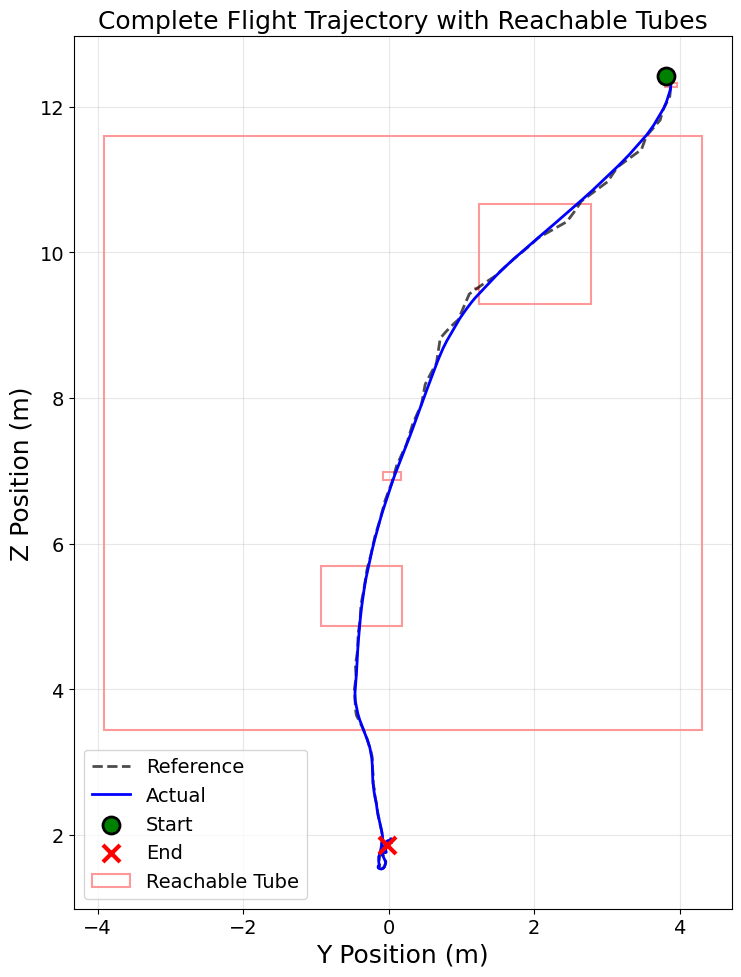

Static plot created and saved as 'log_static_plot.png'!


In [5]:
# Create a static plot showing the full trajectory
fig, ax = plt.subplots(figsize=(12, 10))

FONTSIZE = 18
LINEWIDTH = 2

# Plot full trajectories
ax.plot(y_ref, z_ref, label='Reference', linestyle='dashed', 
         color='black', linewidth=LINEWIDTH, alpha=0.7)
ax.plot(y, z, label='Actual', color='blue', linewidth=LINEWIDTH)

# Find first and last non-NaN values
start_idx = 0
for i in range(len(y)):
    if not (np.isnan(y[i]) or np.isnan(z[i])):
        start_idx = i
        break

end_idx = len(y) - 1
for i in range(len(y) - 1, -1, -1):
    if not (np.isnan(y[i]) or np.isnan(z[i])):
        end_idx = i
        break

# Plot start and end positions
ax.scatter(y[start_idx], z[start_idx], color='green', s=150, 
           marker='o', label='Start', zorder=5, edgecolors='black', linewidths=2)
ax.scatter(y[end_idx], z[end_idx], color='red', s=150, 
           marker='x', label='End', zorder=5, linewidths=3)

# Plot reachable tube at multiple points along the trajectory
num_tubes = 10
tube_indices = np.linspace(start_idx, end_idx, num_tubes, dtype=int)

for i, idx in enumerate(tube_indices):
    if not (np.isnan(pyL[idx]) or np.isnan(pzL[idx]) or 
            np.isnan(pyH[idx]) or np.isnan(pzH[idx])):
        rect = Rectangle((pyL[idx], pzL[idx]), 
                        pyH[idx] - pyL[idx], 
                        pzH[idx] - pzL[idx],
                        linewidth=1.5, edgecolor='red', facecolor='none', 
                        alpha=0.4, linestyle='-')
        ax.add_patch(rect)
        if i == 0:
            rect.set_label('Reachable Tube')

ax.set_xlabel('Y Position (m)', fontsize=FONTSIZE)
ax.set_ylabel('Z Position (m)', fontsize=FONTSIZE)
ax.set_title('Complete Flight Trajectory with Reachable Tubes', fontsize=FONTSIZE)
ax.legend(fontsize=FONTSIZE - 4, loc='best')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('log_static_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("Static plot created and saved as 'log_static_plot.png'!")